# Tanzania Tourism Prediction

The objective of this hackathon is to develop a machine learning model to predict what a tourist will spend when visiting Tanzania.The model can be used by different tour operators and the Tanzania Tourism Board to automatically help tourists across the world estimate their expenditure before visiting Tanzania.

# Import

In [58]:
import os

import numpy as np
import pandas as pd

from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from timeit import default_timer as timer


# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

# Getting the Data

In [59]:
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')

In [60]:
train.head()


,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.00,0.00,Cash,No,Friendly People,"674,602.50"
1,tour_10,UNITED KINGDOM,25-44,NaN,1.00,0.00,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.00,7.00,Cash,Yes,"Wonderful Country, Landscape, Nature","3,214,906.50"
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.00,1.00,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.00,31.00,Cash,No,Excellent Experience,"3,315,000.00"
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.00,0.00,Cash,Yes,Friendly People,"7,790,250.00"
4,tour_1004,CHINA,1-24,NaN,1.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.00,4.00,Cash,Yes,No comments,"1,657,500.00"


In [61]:
#Print the shape of the data
print('Train dataset:')
print('# observations: {}'.format(train.shape[0]))
print('# features:     {}'.format(train.shape[1]-1))
print('==================')
print('Test dataset:')
print('# observations: {}'.format(test.shape[0]))
print('# features:     {}'.format(test.shape[1]-1))

Train dataset:
# observations: 4809
# features:     22
Test dataset:
# observations: 1601
# features:     21


In [62]:
#Exploring the Train-Data
train.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost'],
      dtype='object')

In [63]:
#Exploring the Test-Data --> "total_cost"-Column is missing
test.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing'],
      dtype='object')

In [64]:
train.info

<bound method DataFrame.info of              ID                   country age_group        travel_with   
0        tour_0                SWIZERLAND     45-64  Friends/Relatives  \
1       tour_10            UNITED KINGDOM     25-44                NaN   
2     tour_1000            UNITED KINGDOM     25-44              Alone   
3     tour_1002            UNITED KINGDOM     25-44             Spouse   
4     tour_1004                     CHINA      1-24                NaN   
...         ...                       ...       ...                ...   
4804   tour_993                       UAE     45-64              Alone   
4805   tour_994  UNITED STATES OF AMERICA     25-44             Spouse   
4806   tour_995               NETHERLANDS      1-24                NaN   
4807   tour_997              SOUTH AFRICA     25-44  Friends/Relatives   
4808   tour_999            UNITED KINGDOM     25-44             Spouse   

      total_female  total_male                         purpose   
0            

In [65]:
#df_train.describe().T

In [66]:
train.isnull().sum()

ID                          0
country                     0
age_group                   0
travel_with              1114
total_female                3
total_male                  5
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing           313
total_cost                  0
dtype: int64

# Data cleaning in and feature engineering

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

In [75]:
# Make all column names lowercase and snake_case
train.columns = (
    train.columns.str.strip()           # remove spaces around names
                 .str.lower()            # lowercase
                 .str.replace(' ', '_') ) # replace spaces with underscores

# Fill missing values in categorical columns
train['travel_with'] = train['travel_with'].fillna('Unknown')
train['most_impressing'] = train['most_impressing'].fillna('No Comments')
train['total_female'] = train['total_female'].fillna(0)
train['total_male'] = train['total_male'].fillna(0)

In [76]:
train.isnull().sum()

id                       0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
dtype: int64

In [68]:
# Make all column names lowercase and snake_case
train.columns = (
    train.columns.str.strip()           # remove spaces around names
                 .str.lower()            # lowercase
                 .str.replace(' ', '_') ) # replace spaces with underscores

# Standardize capitalization and remove spaces
text_cols = [
    'country', 'age_group', 'travel_with', 'purpose', 'main_activity',
    'info_source', 'tour_arrangement', 'payment_mode', 'most_impressing']
# CONVERT binary Yes/No columns to numeric (1/0) 
binary_cols = ['package_transport_int', 'package_accomodation', 'package_food',
    'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
    'package_insurance', 'first_trip_tz']

# Replace 'Yes' with 1 and 'No' with 0 for each binary column for both train and test datasets
for col in binary_cols:
    train[col] = train[col].map({'Yes': 1, 'No': 0})
    test[col] = test[col].map({'Yes': 1, 'No': 0})

cat_cols = [
    'country', 'travel_with', 'purpose', 'main_activity',
    'info_source', 'tour_arrangement', 'payment_mode', 'most_impressing'
]
# Apply one-hot encoding to both train and test sets --> expands categorical columns into multiple binary columns --> makes no sense
# for col in cat_cols:
#    train = pd.get_dummies(train, columns=[col], drop_first=True)
#    test = pd.get_dummies(test, columns=[col], drop_first=True)

train, test = train.align(test, join='left', axis=1, fill_value=0)

# --- CHECK shapes and verify data ---
print("✅ Encoding complete!")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Check a few first columns to confirm encoding worked
print("\nEncoded train columns preview:\n", train.columns[:15].tolist())

✅ Encoding complete!
Train shape: (4809, 23)
Test shape: (1601, 23)

Encoded train columns preview:
 ['id', 'country', 'age_group', 'travel_with', 'total_female', 'total_male', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing']


In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   int64  
 11  package_accomodation   4809 non-null   int64  
 12  package_food           4809 non-null   int64  
 13  package_transport_tz   4809 non-null   int64  
 14  package_sightseeing    4809 non-null   int64  
 15  pack

In [70]:
# --- Identify boolean columns ---
bool_cols = train.select_dtypes(include='bool').columns
print("🔍 Found", len(bool_cols), "boolean columns.")

# --- Convert bool → int (True=1, False=0) for both train and test ---
train[bool_cols] = train[bool_cols].astype(int)

# Intersection ensures only common columns are converted
test[bool_cols.intersection(test.columns)] = (
    test[bool_cols.intersection(test.columns)].astype(int)
)

# --- Check result ---
print("\n✅ After dtype conversion:")
print(train.info())

🔍 Found 0 boolean columns.

✅ After dtype conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   int64  
 11  package_accomodation   4809 non-null   int64  
 12  package_food           4809 non-null   int64  
 13  package_transport_tz   4809 non-null   int64  
 14  pa

Correlation Visualisation

In [71]:
# Select only numeric columns
numeric_cols = raw_train.select_dtypes(include=['int64', 'float64'])
print("Numeric columns used for correlation:\n", numeric_cols.columns.tolist())

Numeric columns used for correlation:
 ['total_female', 'total_male', 'night_mainland', 'night_zanzibar', 'total_cost']


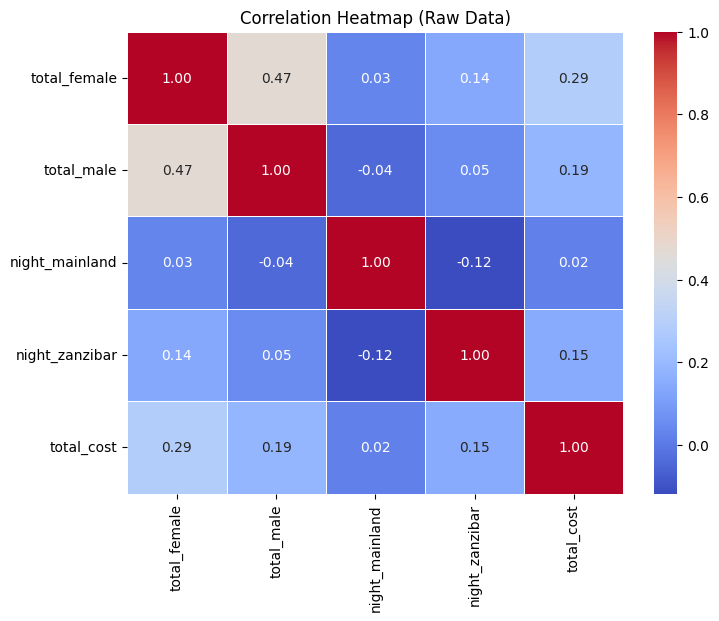

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Raw Data)')
plt.show()

# Correlation Visualisation of the Data

## Splitting data for testing 

## Trainining the model